In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob
import torch.nn.functional as F

c:\Users\peter\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import torch

if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Reserved : {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"Max Alloc: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Max Rsvd : {torch.cuda.max_memory_reserved(0) / 1024**2:.2f} MB")
else:
    print("CUDA not available.")


Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Allocated: 16.37 MB
Reserved : 9402.00 MB
Max Alloc: 7823.43 MB
Max Rsvd : 9402.00 MB


In [3]:

freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
#lag everything realtive to total volume
df['total_volume'] = df['total_volume'].shift(1)
#drop the first row
df = df.dropna()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


In [4]:
print(np.mean(df["total_volume"]))
print(np.std(df["total_volume"]))

5.526706900948502
15.539748705288192


In [5]:
"""
freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
"""

"\nfreq='5min'\ntrx_df = read_txn_data(use_load=False)\nlob_df = create_lob_dataset(use_load=False)\ntrx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)\ndf = merge_txn_and_lob(trx_df, lob_df)\n"

In [6]:
"""
print(np.mean(df["total_volume"]))
print(np.std(df["total_volume"]))
"""

'\nprint(np.mean(df["total_volume"]))\nprint(np.std(df["total_volume"]))\n'

In [7]:
"""
freq='10min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
"""

"\nfreq='10min'\ntrx_df = read_txn_data(use_load=False)\nlob_df = create_lob_dataset(use_load=False)\ntrx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)\ndf = merge_txn_and_lob(trx_df, lob_df)\n"

In [8]:
"""
print(np.mean(df["total_volume"]))
print(np.std(df["total_volume"]))
"""

'\nprint(np.mean(df["total_volume"]))\nprint(np.std(df["total_volume"]))\n'

In [9]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
def recalc(df: pd.DataFrame, train_size: float = 0.9) -> pd.DataFrame:
    df = df.copy()
    df['time'] = df['datetime'].dt.time
    train_idx = int(len(df) * train_size)
    train, rest = df.iloc[:train_idx], df.iloc[train_idx:]

    # Compute mean_volume for training data and replace zeros
    train['mean_volume'] = train.groupby('time')['total_volume'].transform('mean')
    train.loc[train['mean_volume'] == 0, 'mean_volume'] = 1e-8  # Prevent division by zero
    train['deseasoned_total_volume'] = train['total_volume'] / train['mean_volume']
    train['log_deseasoned_total_volume'] = np.log(train['deseasoned_total_volume'].clip(lower=1e-8))

    # Handle test data
    rest = rest.merge(
        train[['time', 'mean_volume']].drop_duplicates('time'),
        on='time', how='left'
    )
    rest.rename(columns={'mean_volume_y': 'mean_volume'}, inplace=True)
    rest.drop(columns=['mean_volume_x'], inplace=True)

    # Fill missing mean_volume with test's total_volume and replace zeros
    rest['mean_volume'].fillna(rest['total_volume'], inplace=True)
    rest.loc[rest['mean_volume'] == 0, 'mean_volume'] = 1e-8  # Prevent division by zero

    rest['deseasoned_total_volume'] = rest['total_volume'] / rest['mean_volume']
    rest['log_deseasoned_total_volume'] = np.log(rest['deseasoned_total_volume'].clip(lower=1e-8))

    return pd.concat([train, rest])

In [11]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

In [12]:
df2=recalc(df)


In [13]:
# robust_tme_cv.py
# =============================================================================
#  Robust Gaussian‑TME with optional L2 regularisation + time‑series CV
# =============================================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────────────────────────────────────────────────────────────────────────
# 1.  data utils
# ─────────────────────────────────────────────────────────────────────────────
TRX_COLS = ["buy_volume", "sell_volume", "buy_txn", "sell_txn",
            "volume_imbalance", "txn_imbalance"]
LOB_COLS = ["ask_volume", "bid_volume", "spread", "lob_volume_imbalance",
            "ask_slope_1", "ask_slope_5", "ask_slope_10",
            "bid_slope_1", "bid_slope_5", "bid_slope_10", "spread"]

class VolumeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, horizon: int, y_mean=None, y_std=None):
        df = recalc(df)
        y_raw = df["log_deseasoned_total_volume"].to_numpy(np.float32)
        self.y_mean = float(y_raw.mean()) if y_mean is None else y_mean
        self.y_std  = float(y_raw.std() + 1e-8) if y_std is None else y_std
        y = (y_raw - self.y_mean) / self.y_std

        self.trx = torch.tensor(df[TRX_COLS].to_numpy(np.float32))
        self.lob = torch.tensor(df[LOB_COLS].to_numpy(np.float32))
        self.y   = torch.tensor(y)
        self.h   = horizon

    def __len__(self): return len(self.y) - self.h
    def __getitem__(self, idx):
        sl = slice(idx, idx + self.h)
        return self.trx[sl], self.lob[sl], self.y[idx + self.h]

# ─────────────────────────────────────────────────────────────────────────────
# 2.  model
# ─────────────────────────────────────────────────────────────────────────────
def bilinear(x, L, R, b):
    B = x.size(0)
    x_flat = x.permute(0, 2, 1).reshape(B, -1)
    return (x_flat @ L).mul(R).sum(1, keepdim=True) + b

class BilinearExpert(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.L_mu = nn.Parameter(torch.randn(d*h,1)*.01);  self.R_mu = nn.Parameter(torch.randn(1)*.01); self.b_mu = nn.Parameter(torch.zeros(1))
        self.L_lv = nn.Parameter(torch.randn(d*h,1)*.01);  self.R_lv = nn.Parameter(torch.randn(1)*.01); self.b_lv = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        mean = bilinear(x, self.L_mu, self.R_mu, self.b_mu)
        logv = bilinear(x, self.L_lv, self.R_lv, self.b_lv)
        var  = F.softplus(logv) + 1e-5
        return mean, var

class BilinearGate(nn.Module):
    def __init__(self, d_all, h, k=2):
        super().__init__()
        self.L = nn.Parameter(torch.randn(d_all*h, k)*.01)
        self.R = nn.Parameter(torch.randn(1, k)*.01)
        self.b = nn.Parameter(torch.zeros(k))
    def forward(self, *src):
        B = src[0].size(0)
        x = torch.cat([s.permute(0,2,1).reshape(B,-1) for s in src], 1)
        return torch.softmax((x @ self.L).mul(self.R) + self.b, 1)

class TME(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.trx = BilinearExpert(len(TRX_COLS), h)
        self.lob = BilinearExpert(len(LOB_COLS), h)
        self.gate = BilinearGate(len(TRX_COLS)+len(LOB_COLS), h)
    def forward(self, trx, lob):
        m1,v1 = self.trx(trx); m2,v2 = self.lob(lob)
        w = self.gate(trx,lob)
        return torch.cat([m1,m2],1), torch.cat([v1,v2],1), w

def nll(pred, y):
    mu, var, w = pred
    w = w.clamp(1e-4,1-1e-4)
    y = y.unsqueeze(1)
    lp = -0.5*(torch.log(2*np.pi*var) + (y-mu)**2/var)
    return -torch.logsumexp(torch.log(w)+lp,1).mean()

# ─────────────────────────────────────────────────────────────────────────────
# 3.  training with L2 + val monitoring
# ─────────────────────────────────────────────────────────────────────────────
def train_tme_cv(df: pd.DataFrame,
                 horizon=100,
                 epochs=20,
                 batch=len(df),
                 l2_lambda=0.1,      
                 use_adamw=True):     
    # ---- time split (80 train / 10 val / 10 test) ----
    n = len(df)
    train_df = df.iloc[:int(0.8*n)]
    val_df   = df.iloc[int(0.8*n):int(0.9*n)]
    test_df  = df.iloc[int(0.9*n):]

    train_ds = VolumeDataset(train_df, horizon)
    val_ds   = VolumeDataset(val_df, horizon,
                             y_mean=train_ds.y_mean, y_std=train_ds.y_std)
    test_ds  = VolumeDataset(test_df, horizon,
                             y_mean=train_ds.y_mean, y_std=train_ds.y_std)

    train_dl = DataLoader(train_ds, batch, shuffle=True)
    val_dl   = DataLoader(val_ds, batch, shuffle=False)

    net  = TME(horizon).double().to(DEVICE)
    opt  = torch.optim.Adam(net.parameters(),lr=1e-3,
                            weight_decay=l2_lambda if use_adamw else 0.0)
    best_val, best_state = np.inf, None
    tr_curve, va_curve   = [], []

    for ep in range(1, epochs+1):
        net.train(); tot=0.
        for trx,lob,y in train_dl:
            trx,lob,y=[t.double().to(DEVICE) for t in (trx,lob,y)]
            opt.zero_grad()
            loss = nll(net(trx,lob), y)
            if not use_adamw and l2_lambda>0:
                l2 = sum(p.pow(2).sum() for p in net.parameters())
                loss = loss + l2_lambda * l2
            loss.backward(); torch.nn.utils.clip_grad_norm_(net.parameters(),1.0)
            opt.step(); tot += loss.item()
        tr_curve.append(tot/len(train_dl))

        # ---- validation ----
        net.eval(); tot=0.
        with torch.no_grad():
            for trx,lob,y in val_dl:
                trx,lob,y=[t.double().to(DEVICE) for t in (trx,lob,y)]
                tot += nll(net(trx,lob), y).item()
        val_loss = tot/len(val_dl); va_curve.append(val_loss)
        print(f"Ep{ep:02d}  train {tr_curve[-1]:.4f}  val {val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            best_state = net.state_dict()

    # load best
    net.load_state_dict(best_state)

    # test loader
    test_dl = DataLoader(test_ds, batch, shuffle=False)
    return net, train_ds, test_dl, tr_curve, va_curve

# ─────────────────────────────────────────────────────────────────────────────
# 4.  evaluation util
# ─────────────────────────────────────────────────────────────────────────────
@torch.no_grad()
def predict_loader(net, loader, ds):
    net.eval(); yt, yp = [],[]
    for trx,lob,y in loader:
        trx,lob,y=[t.double().to(DEVICE) for t in (trx,lob,y)]
        mu,var,w = net(trx,lob)
        pred = (w*mu).sum(1)
        yt.append((y*ds.y_std+ds.y_mean).cpu().numpy())
        yp.append((pred*ds.y_std+ds.y_mean).cpu().numpy())
    return np.concatenate(yt), np.concatenate(yp)



# 1 min

In [ ]:

freq='1min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
#lag everything realtive to total volume
df['total_volume'] = df['total_volume'].shift(1)
#drop the first row
df = df.dropna()

Ep01  train 10.6655  val 10.9399
Ep02  train 10.6590  val 1.7255
Ep03  train 1.4479  val 1.7194
Ep04  train 1.4398  val 1.7144
Ep05  train 1.4328  val 1.7098
Ep06  train 1.4278  val 1.7053
Ep07  train 1.4253  val 1.7001
Ep08  train 1.4243  val 1.6942
Ep09  train 1.4229  val 1.6881
Ep10  train 1.4213  val 1.6821
Ep11  train 1.4193  val 1.6770
Ep12  train 1.4170  val 1.6727
Ep13  train 1.4147  val 1.6708
Ep14  train 1.4128  val 1.6702
Ep15  train 1.4111  val 1.6697
Ep16  train 1.4093  val 1.6693
Ep17  train 1.4074  val 1.6691
Ep18  train 1.4054  val 1.6694
Ep19  train 1.4033  val 1.6695
Ep20  train 1.4010  val 1.6694


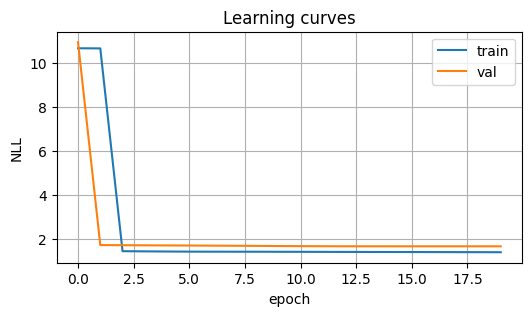

Test RMSE 2.1763  MAE 1.7299  R² 0.0353  MAPE 603.43%


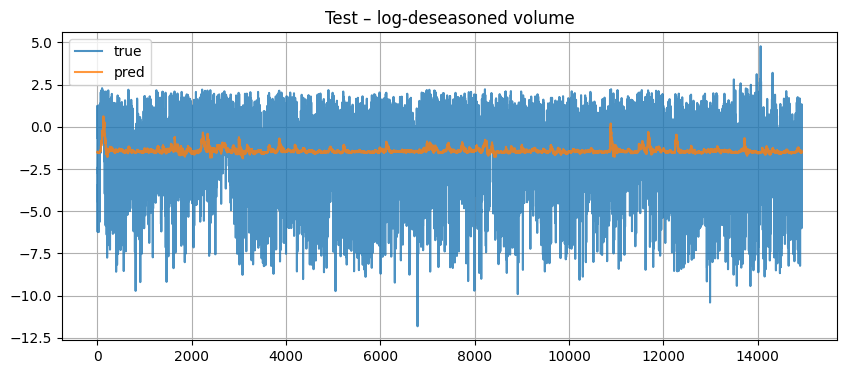

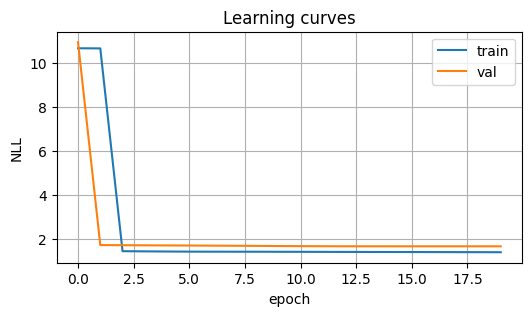

Test metrics (original volume)
  RMSE  11.53
  MAE   3.89
  R²    0.0406
  MAPE  2529.79%


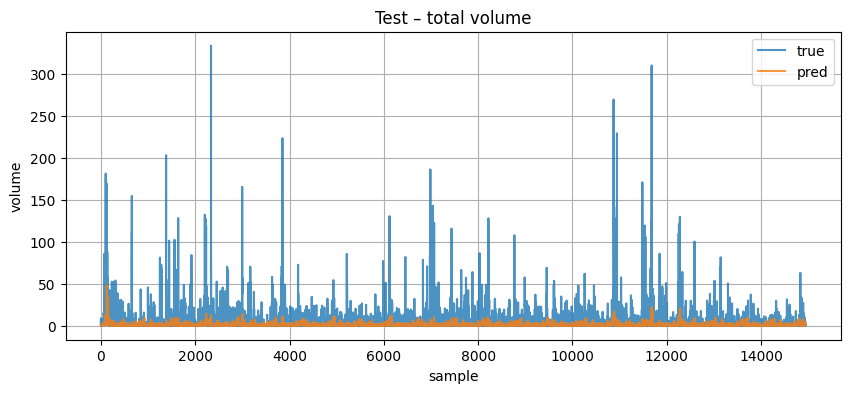

In [16]:
net, ds_train, test_loader, tr_curve, va_curve = train_tme_cv(
    df, horizon=100, epochs=20,
    l2_lambda=1e-4,   # set 0 for no L2, or increase for stronger reg
    use_adamw=True)   # False → manual λ ‖Θ‖² inside loss

# --- learning curves ---
plt.figure(figsize=(6,3))
plt.plot(tr_curve,label="train")
plt.plot(va_curve,label="val")
plt.xlabel("epoch"); plt.ylabel("NLL"); plt.title("Learning curves")
plt.grid(True); plt.legend(); plt.show()

# --- test metrics & plot ---
y_true, y_pred = predict_loader(net, test_loader, ds_train)
rmse=np.sqrt(mean_squared_error(y_true,y_pred))
mae = mean_absolute_error(y_true,y_pred)
r2  = r2_score(y_true,y_pred)
mape=np.mean(np.abs((y_true-y_pred)/y_true))*100


print(f"Test RMSE {rmse:.4f}  MAE {mae:.4f}  R² {r2:.4f}  MAPE {mape:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(y_true,label="true",alpha=.8)
plt.plot(y_pred,label="pred",alpha=.8)
plt.title("Test – log‑deseasoned volume"); plt.grid(True); plt.legend()
plt.show()


# ------------------------------------------------------------------
# train / val / test + learning‑curve (unchanged)
# ------------------------------------------------------------------
#net, ds_train, test_loader, tr_curve, va_curve = train_tme_cv(
#    df, horizon=100, epochs=20,
#    l2_lambda=1e-4, use_adamw=True)

plt.figure(figsize=(6,3))
plt.plot(tr_curve, label="train")
plt.plot(va_curve, label="val")
plt.xlabel("epoch"); plt.ylabel("NLL"); plt.title("Learning curves")
plt.grid(True); plt.legend(); plt.show()

# ------------------------------------------------------------------
#  convert log‑deseasoned  →  raw volume
# ------------------------------------------------------------------
# 1) get log‑scale predictions and ground‑truth
y_true_log, y_pred_log = predict_loader(net, test_loader, ds_train)

# 2) fetch the per‑row seasonality factor  (mean_volume)  so that
#    exp(log‑deseas) * mean_volume  =  original total_volume
#    NOTE: indexes align because VolumeDataset drops the first `h` rows.
test_df     = df.iloc[int(len(df)*0.9):].copy()
test_df_rec = recalc(test_df)                              # adds mean_volume
mean_vol    = test_df_rec["mean_volume"].to_numpy()[100:]  # skip horizon

# 3) undo log + deseasonalisation
y_true_vol = np.exp(y_true_log) * mean_vol
y_pred_vol = np.exp(y_pred_log) * mean_vol

# ------------------------------------------------------------------
#  error metrics on VOLUME scale
# ------------------------------------------------------------------
rmse  = np.sqrt(mean_squared_error(y_true_vol, y_pred_vol))
mae   = mean_absolute_error(y_true_vol, y_pred_vol)
r2    = r2_score(y_true_vol, y_pred_vol)
mape  = np.mean(np.abs((y_true_vol - y_pred_vol) / y_true_vol)) * 100

print("Test metrics (original volume)")
print(f"  RMSE  {rmse:.2f}")
print(f"  MAE   {mae:.2f}")
print(f"  R²    {r2:.4f}")
print(f"  MAPE  {mape:.2f}%")

# ------------------------------------------------------------------
#  plot on volume scale
# ------------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_true_vol, label="true", alpha=.8)
plt.plot(y_pred_vol, label="pred", alpha=.8)
plt.title("Test – total volume"); plt.grid(True); plt.legend()
plt.xlabel("sample"); plt.ylabel("volume")
plt.show()

# 5 min

In [17]:


freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
#lag everything realtive to total volume
df['total_volume'] = df['total_volume'].shift(1)
#drop the first row
df = df.dropna()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


Ep01  train 1.4961  val 1.7652
Ep02  train 1.4356  val 1.7471
Ep03  train 1.4350  val 1.7392
Ep04  train 1.4292  val 1.7374
Ep05  train 1.4178  val 1.7424
Ep06  train 1.4094  val 1.7487
Ep07  train 1.4058  val 1.7519
Ep08  train 1.4032  val 1.7506
Ep09  train 1.3980  val 1.7453
Ep10  train 1.3901  val 1.7377
Ep11  train 1.3815  val 1.7293
Ep12  train 1.3747  val 1.7215
Ep13  train 1.3706  val 1.7154
Ep14  train 1.3656  val 1.7115
Ep15  train 1.3576  val 1.7098
Ep16  train 1.3517  val 1.7075
Ep17  train 1.3485  val 1.7010
Ep18  train 1.3427  val 1.6903
Ep19  train 1.3356  val 1.6803
Ep20  train 1.3315  val 1.6738


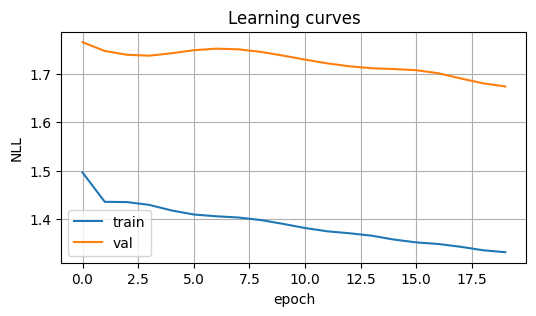

Test RMSE 1.3960  MAE 1.0515  R² 0.0735  MAPE 439.30%


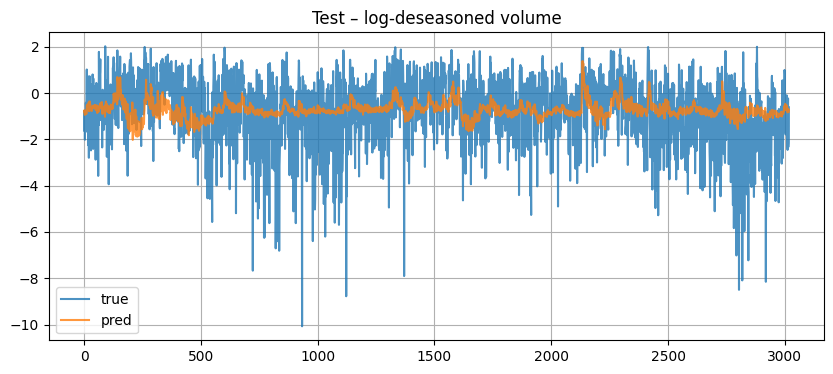

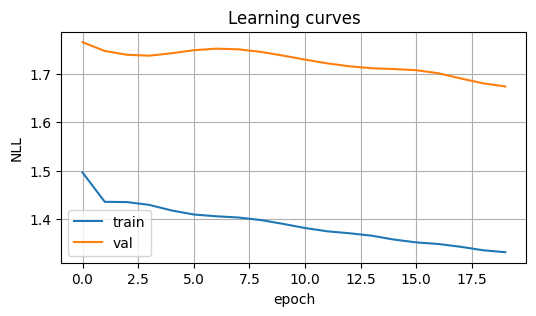

Test metrics (original volume)
  RMSE  30.62
  MAE   14.14
  R²    0.2198
  MAPE  1038.85%


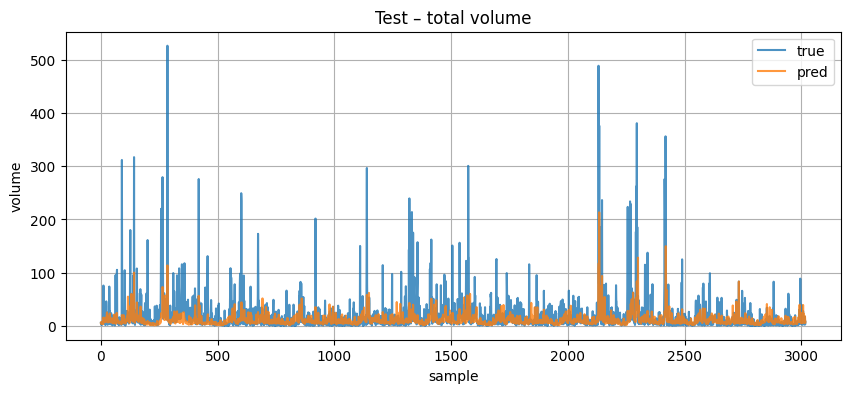

In [18]:
net, ds_train, test_loader, tr_curve, va_curve = train_tme_cv(
    df, horizon=100, epochs=20,
    l2_lambda=1e-4,   # set 0 for no L2, or increase for stronger reg
    use_adamw=True)   # False → manual λ ‖Θ‖² inside loss

# --- learning curves ---
plt.figure(figsize=(6,3))
plt.plot(tr_curve,label="train")
plt.plot(va_curve,label="val")
plt.xlabel("epoch"); plt.ylabel("NLL"); plt.title("Learning curves")
plt.grid(True); plt.legend(); plt.show()

# --- test metrics & plot ---
y_true, y_pred = predict_loader(net, test_loader, ds_train)
rmse=np.sqrt(mean_squared_error(y_true,y_pred))
mae = mean_absolute_error(y_true,y_pred)
r2  = r2_score(y_true,y_pred)
mape=np.mean(np.abs((y_true-y_pred)/y_true))*100


print(f"Test RMSE {rmse:.4f}  MAE {mae:.4f}  R² {r2:.4f}  MAPE {mape:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(y_true,label="true",alpha=.8)
plt.plot(y_pred,label="pred",alpha=.8)
plt.title("Test – log‑deseasoned volume"); plt.grid(True); plt.legend()
plt.show()


# ------------------------------------------------------------------
# train / val / test + learning‑curve (unchanged)
# ------------------------------------------------------------------
#net, ds_train, test_loader, tr_curve, va_curve = train_tme_cv(
#    df, horizon=100, epochs=20,
#    l2_lambda=1e-4, use_adamw=True)

plt.figure(figsize=(6,3))
plt.plot(tr_curve, label="train")
plt.plot(va_curve, label="val")
plt.xlabel("epoch"); plt.ylabel("NLL"); plt.title("Learning curves")
plt.grid(True); plt.legend(); plt.show()

# ------------------------------------------------------------------
#  convert log‑deseasoned  →  raw volume
# ------------------------------------------------------------------
# 1) get log‑scale predictions and ground‑truth
y_true_log, y_pred_log = predict_loader(net, test_loader, ds_train)

# 2) fetch the per‑row seasonality factor  (mean_volume)  so that
#    exp(log‑deseas) * mean_volume  =  original total_volume
#    NOTE: indexes align because VolumeDataset drops the first `h` rows.
test_df     = df.iloc[int(len(df)*0.9):].copy()
test_df_rec = recalc(test_df)                              # adds mean_volume
mean_vol    = test_df_rec["mean_volume"].to_numpy()[100:]  # skip horizon

# 3) undo log + deseasonalisation
y_true_vol = np.exp(y_true_log) * mean_vol
y_pred_vol = np.exp(y_pred_log) * mean_vol

# ------------------------------------------------------------------
#  error metrics on VOLUME scale
# ------------------------------------------------------------------
rmse  = np.sqrt(mean_squared_error(y_true_vol, y_pred_vol))
mae   = mean_absolute_error(y_true_vol, y_pred_vol)
r2    = r2_score(y_true_vol, y_pred_vol)
mape  = np.mean(np.abs((y_true_vol - y_pred_vol) / y_true_vol)) * 100

print("Test metrics (original volume)")
print(f"  RMSE  {rmse:.2f}")
print(f"  MAE   {mae:.2f}")
print(f"  R²    {r2:.4f}")
print(f"  MAPE  {mape:.2f}%")

# ------------------------------------------------------------------
#  plot on volume scale
# ------------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_true_vol, label="true", alpha=.8)
plt.plot(y_pred_vol, label="pred", alpha=.8)
plt.title("Test – total volume"); plt.grid(True); plt.legend()
plt.xlabel("sample"); plt.ylabel("volume")
plt.show()

# 10 min

In [19]:


freq='10min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df = merge_txn_and_lob(trx_df, lob_df)
#lag everything realtive to total volume
df['total_volume'] = df['total_volume'].shift(1)
#drop the first row
df = df.dropna()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


Ep01  train 10.7918  val 10.9643
Ep02  train 10.6532  val 7.3308
Ep03  train 7.7641  val 4.6806
Ep04  train 4.7346  val 1.6786
Ep05  train 1.5076  val 1.6774
Ep06  train 1.5073  val 1.6769
Ep07  train 1.4984  val 1.6796
Ep08  train 1.4803  val 1.6865
Ep09  train 1.4569  val 1.6966
Ep10  train 1.4312  val 1.7086
Ep11  train 1.4071  val 1.7224
Ep12  train 1.3905  val 1.7348
Ep13  train 1.3865  val 1.7424
Ep14  train 1.3882  val 1.7409
Ep15  train 1.3765  val 1.7347
Ep16  train 1.3648  val 1.7201
Ep17  train 1.3537  val 1.6952
Ep18  train 1.3410  val 1.6758
Ep19  train 1.3338  val 1.6675
Ep20  train 1.3269  val 1.6575


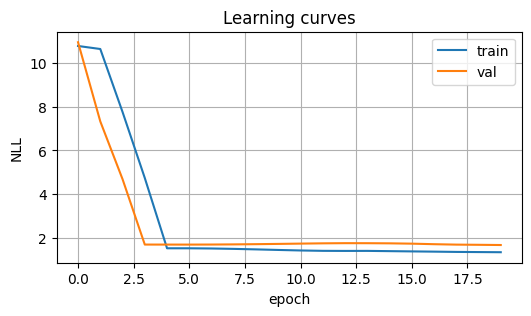

Test RMSE 1.0848  MAE 0.8506  R² 0.0787  MAPE 1074.75%


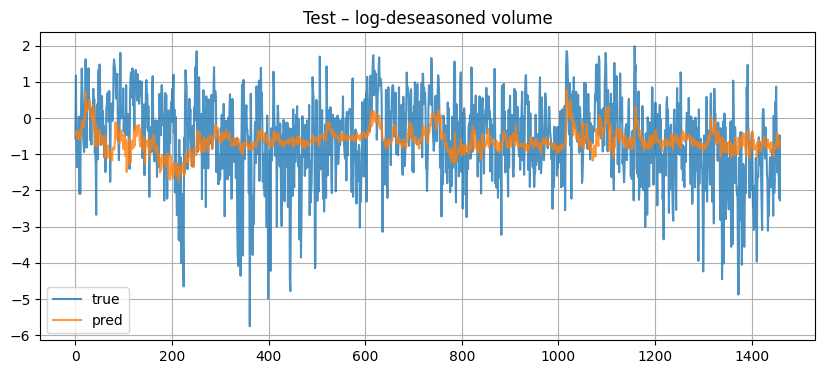

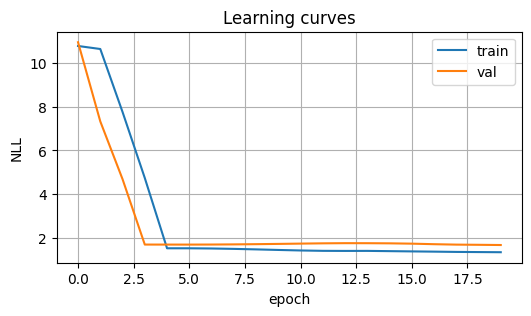

Test metrics (original volume)
  RMSE  52.70
  MAE   25.95
  R²    0.1672
  MAPE  162.53%


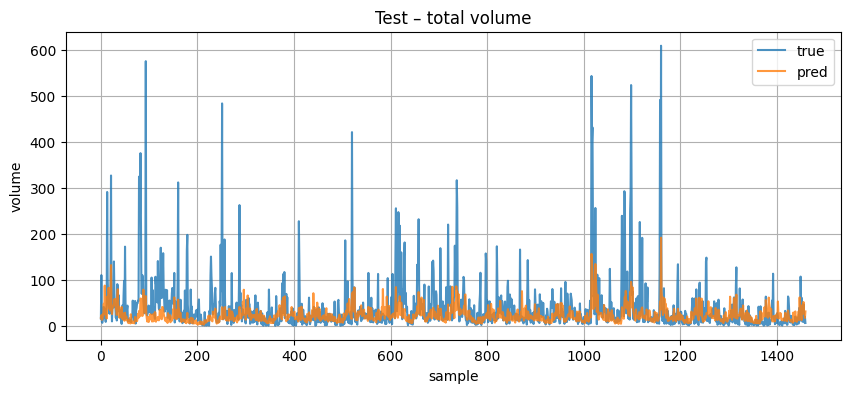

In [22]:
net, ds_train, test_loader, tr_curve, va_curve = train_tme_cv(
    df, horizon=100, epochs=20,
    l2_lambda=1e-4,   # set 0 for no L2, or increase for stronger reg
    use_adamw=True)   # False → manual λ ‖Θ‖² inside loss

# --- learning curves ---
plt.figure(figsize=(6,3))
plt.plot(tr_curve,label="train")
plt.plot(va_curve,label="val")
plt.xlabel("epoch"); plt.ylabel("NLL"); plt.title("Learning curves")
plt.grid(True); plt.legend(); plt.show()

# --- test metrics & plot ---
y_true, y_pred = predict_loader(net, test_loader, ds_train)
rmse=np.sqrt(mean_squared_error(y_true,y_pred))
mae = mean_absolute_error(y_true,y_pred)
r2  = r2_score(y_true,y_pred)
mape=np.mean(np.abs((y_true-y_pred)/y_true))*100


print(f"Test RMSE {rmse:.4f}  MAE {mae:.4f}  R² {r2:.4f}  MAPE {mape:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(y_true,label="true",alpha=.8)
plt.plot(y_pred,label="pred",alpha=.8)
plt.title("Test – log‑deseasoned volume"); plt.grid(True); plt.legend()
plt.show()


# ------------------------------------------------------------------
# train / val / test + learning‑curve (unchanged)
# ------------------------------------------------------------------
#net, ds_train, test_loader, tr_curve, va_curve = train_tme_cv(
#    df, horizon=100, epochs=20,
#    l2_lambda=1e-4, use_adamw=True)

plt.figure(figsize=(6,3))
plt.plot(tr_curve, label="train")
plt.plot(va_curve, label="val")
plt.xlabel("epoch"); plt.ylabel("NLL"); plt.title("Learning curves")
plt.grid(True); plt.legend(); plt.show()

# ------------------------------------------------------------------
#  convert log‑deseasoned  →  raw volume
# ------------------------------------------------------------------
# 1) get log‑scale predictions and ground‑truth
y_true_log, y_pred_log = predict_loader(net, test_loader, ds_train)

# 2) fetch the per‑row seasonality factor  (mean_volume)  so that
#    exp(log‑deseas) * mean_volume  =  original total_volume
#    NOTE: indexes align because VolumeDataset drops the first `h` rows.
test_df     = df.iloc[int(len(df)*0.9):].copy()
test_df_rec = recalc(test_df)                              # adds mean_volume
mean_vol    = test_df_rec["mean_volume"].to_numpy()[100:]  # skip horizon

# 3) undo log + deseasonalisation
y_true_vol = np.exp(y_true_log) * mean_vol
y_pred_vol = np.exp(y_pred_log) * mean_vol

# ------------------------------------------------------------------
#  error metrics on VOLUME scale
# ------------------------------------------------------------------
rmse  = np.sqrt(mean_squared_error(y_true_vol, y_pred_vol))
mae   = mean_absolute_error(y_true_vol, y_pred_vol)
r2    = r2_score(y_true_vol, y_pred_vol)
mape  = np.mean(np.abs((y_true_vol - y_pred_vol) / y_true_vol)) * 100

print("Test metrics (original volume)")
print(f"  RMSE  {rmse:.2f}")
print(f"  MAE   {mae:.2f}")
print(f"  R²    {r2:.4f}")
print(f"  MAPE  {mape:.2f}%")

# ------------------------------------------------------------------
#  plot on volume scale
# ------------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_true_vol, label="true", alpha=.8)
plt.plot(y_pred_vol, label="pred", alpha=.8)
plt.title("Test – total volume"); plt.grid(True); plt.legend()
plt.xlabel("sample"); plt.ylabel("volume")
plt.show()